Imports

In [1]:
import sys, json, random, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Add project root to PYTHONPATH so relative imports work
sys.path.insert(0, "./")                      # adjust if notebook lives elsewhere

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from training.losses import CoxLoss


In [ ]:
CHECKPOINTS = {
    "baseline": "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best_val_loss.pth",
    "gcs"     : "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4_best_val_loss.pth",
}
DATA_CFG = dict(                         # mirrors the JSON config you train with
    fold                = 0,
    split               = "test",        # use held-out data for fair comparison
    ct_path             = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path            = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path  = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality      = "both",
    require_both_modalities = True,
    pairing_mode           = "one_to_one",
    allow_repeats          = False,
    pairs_per_patient      = None,
)
BATCH_SIZE_EVAL  = 16          # bigger → faster, mind VRAM
GRID_EXTENT      = 1.0         # how far to move (in ‖θ‖ units) along each dir
GRID_STEPS       = 51          # resolution: odd ⇒ centre cell is θ*

SEED             = 0


In [2]:
SEED = 0
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    # Python's built-in random module
    random.seed(seed)

    # Numpy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Configure PyTorch to make computations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_global_seed(seed=SEED)

In [ ]:
from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone



model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)

model.load_state_dict("./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4_best_val_loss.pth", map_location="cuda:0")



TypeError: load_state_dict() got an unexpected keyword argument 'map_location'

## Loss Landscape of model without GCS

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from tqdm.auto import tqdm


def plot_loss_landscape(model,
                        data_loader,
                        criterion,
                        extent=1.0,
                        steps=51,
                        device=None,
                        reduce='mean',
                        forward_kwargs_fn=None,
                        desc="Scanning landscape"):
    """
    Visualise the loss landscape around the current parameters.

    Args
    ----
    model            : nn.Module (already loaded with a checkpoint)
    data_loader      : torch.utils.data.DataLoader returning dict-like batches
    criterion        : loss function that consumes (pred, *targets)
    extent, steps    : sweep range and grid resolution for each axis
    device           : torch.device or str; defaults to model’s own device
    reduce           : 'mean' or 'sum' across dataset when computing loss
    forward_kwargs_fn: optional fn(batch, device) -> kwargs for model(...)
                       (handy if your batch structure differs)
    Returns
    -------
    fig, (alphas, betas, losses)  – so you can reuse the numbers later
    """

    # ------------------------------------------------------------------ setup
    if device is None:
        device = next(model.parameters()).device
    model, criterion = model.to(device), criterion.to(device)
    model.eval()                                      # turn off dropout, etc.

    θ = parameters_to_vector(model.parameters()).detach()

    # two orthonormal random directions d1, d2 ⟂ θ
    d1 = torch.randn_like(θ); d1 -= (d1 @ θ) / (θ @ θ) * θ; d1 /= d1.norm()
    d2 = torch.randn_like(θ); d2 -= (d2 @ θ) / (θ @ θ) * θ
    d2 -= (d2 @ d1) / (d1 @ d1) * d1; d2 /= d2.norm()

    alphas = np.linspace(-extent, extent, steps)
    betas  = np.linspace(-extent, extent, steps)
    losses = np.empty((steps, steps), dtype=np.float32)

    # -------------------------------------------------------- helper: dataset
    @torch.no_grad()
    def _dataset_loss():
        running, n = 0.0, 0
        for batch in data_loader:
            if forward_kwargs_fn is None:                      # default layout
                kwargs = dict(
                    rad_feature=batch["ct_feature"].to(device),
                    histo_feature=batch["wsi_feature"].to(device),
                    modality_flag=batch["modality_mask"].to(device),
                )
                targets = (batch["survtime"].to(device),
                           batch["censor"].to(device))
            else:                                              # user override
                kwargs, targets = forward_kwargs_fn(batch, device)

            hazard = model(**kwargs)["hazard"]
            loss   = criterion(hazard, *targets)
            bs     = hazard.size(0)
            running += loss.item() * (bs if reduce == 'mean' else 1.)
            n      += bs
        return running / n if reduce == 'mean' else running

    baseline = _dataset_loss()                                 # θ*
    # ------------------------------------------------------ grid evaluation
    pbar = tqdm(range(steps), desc=desc)
    for i in pbar:
        a = alphas[i]
        for j, b in enumerate(betas):
            vector_to_parameters(θ + a * d1 + b * d2, model.parameters())
            losses[i, j] = _dataset_loss()
    vector_to_parameters(θ, model.parameters())                # restore weights

    # ------------------------------------------------------------- plotting
    fig, ax = plt.subplots(figsize=(6, 5))
    cf = ax.contourf(betas, alphas, losses - baseline,
                     levels=50, antialiased=True)
    ax.set_xlabel(r"$\beta$ direction")
    ax.set_ylabel(r"$\alpha$ direction")
    ax.set_title("Loss landscape (Δ loss from optimum)")
    fig.colorbar(cf, ax=ax, label="Δ loss")
    plt.tight_layout()
    return fig, (alphas, betas, losses)


/home/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D# <- new
def plot_loss_landscape_3d(model,
                           data_loader,
                           criterion,
                           extent=1.0,
                           steps=51,
                           device=None,
                           reduce='mean',
                           forward_kwargs_fn=None,
                           cmap='viridis',
                           elev=35, azim=-60, rstride=1, cstride=1, directions=None, title="3D Loss Landscape"):

    
        
    # ---------- same setup & scanning code as before -------------------------
    if device is None:
        device = next(model.parameters()).device
    model, criterion = model.to(device), criterion.to(device)
    model.eval()

    θ = torch.nn.utils.parameters_to_vector(model.parameters()).detach()
    
    if directions is None:
        d1 = torch.randn_like(θ); d1 -= (d1 @ θ)/(θ@θ)*θ; d1 /= d1.norm()
        d2 = torch.randn_like(θ); d2 -= (d2 @ θ)/(θ@θ)*θ; d2 -= (d2 @ d1)/(d1@d1)*d1
        d2 /= d2.norm()
    else:
        d1,d2 = directions
    alphas = np.linspace(-extent, extent, steps)
    betas  = np.linspace(-extent, extent, steps)
    losses = np.empty((steps, steps), dtype=np.float32)

    @torch.no_grad()
    def _dataset_loss():
        run, n = 0.0, 0
        for batch in data_loader:
            if forward_kwargs_fn is None:
                kwargs = dict(
                    rad_feature   = batch["ct_feature"].to(device),
                    histo_feature = batch["wsi_feature"].to(device),
                    modality_flag = batch["modality_mask"].to(device),
                )
                targets = (batch["survtime"].to(device),
                           batch["censor"].to(device))
            else:
                kwargs, targets = forward_kwargs_fn(batch, device)

            hazard = model(**kwargs)["hazard"]
            loss   = criterion(hazard, *targets)
            bs     = hazard.size(0)
            run += loss.item() * (bs if reduce == 'mean' else 1.)
            n   += bs
        return run / n if reduce == 'mean' else run

    base_loss = _dataset_loss()
    
    pbar = tqdm(range(steps), desc="Scanning landscape")
    for i in pbar:
        a = alphas[i]
        for j, b in enumerate(betas):
            vector_to_parameters(θ + a * d1 + b * d2, model.parameters())
            losses[i, j] = _dataset_loss()
    vector_to_parameters(θ, model.parameters())   

    # ------------------- 3-D surface plot ------------------------------------
    A, B = np.meshgrid(alphas, betas, indexing='ij')  # same shape as `losses`
    fig  = plt.figure(figsize=(7, 5))
    ax   = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(B, A, losses,
                           cmap=cmap, linewidth=0, antialiased=True,
                           rstride=rstride, cstride=cstride)
    
    #mark_kwargs = dict(s=80, color='red', marker='*', depthshade=False)
    ax.text(0, 0, base_loss, '★', color='red', fontsize=18, ha='center', va='center')
    #ax.legend(loc='upper right')
    star_legend = Line2D([0], [0], marker='*', color='w', label='Base model\n(no perturbation)',
                     markerfacecolor='red', markersize=10)

    # Add the legend to the plot
    #ax.legend(handles=[star_legend], loc='upper left', bbox_to_anchor=(1.05, 1.0))
    ax.set_xlabel(r"$\beta$ direction")
    ax.set_ylabel(r"$\alpha$ direction")
    ax.set_zlabel("Δ loss")
    #ax.set_title(title, loc='right', pad=20)
    ax.view_init(elev=elev, azim=azim)               # camera angle
    fig.colorbar(surf, shrink=0.6, pad=0.08, label="Δ loss")
    plt.tight_layout()
    return fig, (alphas, betas, losses)


In [31]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from torch.utils.data import DataLoader
from training.losses import CoxLoss
device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)

train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "train",        # use held-out data for fair comparison
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path  = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = True,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
) 
train_loader = DataLoader(
        train_ds,
        batch_size=16,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

criterion = CoxLoss()
fig, _ = plot_loss_landscape(model_nogcs,
                             train_loader,
                             criterion,
                             extent=1.0,
                             steps=41,
                             device=device)
plt.show()

NameError: name 'plot_loss_landscape' is not defined

In [50]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict
device = "cuda:0"
set_global_seed(seed=SEED)
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_latest.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model_nogcs.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)

#model_nogcs.load_state_dict(torch.load("./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best_val_loss.pth", weights_only=False))

train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "train",        # use held-out data for fair comparison
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path  = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
) 
train_loader = DataLoader(
        train_ds,
        batch_size=16,
        shuffle=False,
        num_workers=8,  
        pin_memory=True
    )

criterion = CoxLoss()
fig, _ = plot_loss_landscape_3d(model_nogcs,
                             train_loader,
                             criterion,
                             extent=.01,
                             steps=40,
                             device=device)
plt.show()

/tmp/ipykernel_1398441/4235298732.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []


Scanning landscape:  22%|██▎       | 9/40 [02:57<10:07, 19.61s/it]Exception ignored in: <function _releaseLock at 0x74f097b29670>
Traceback (most recent call last):
  File "/home/pietro.caforio/anaconda3/envs/research_biocv_proj/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Scanning landscape:  22%|██▎       | 9/40 [03:17<11:21, 21.98s/it]


RuntimeError: DataLoader worker (pid(s) 2278873, 2278874, 2278875, 2278876, 2278877, 2278878) exited unexpectedly

/tmp/ipykernel_1398441/3794191120.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []


Scanning landscape: 100%|██████████| 40/40 [09:30<00:00, 14.27s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


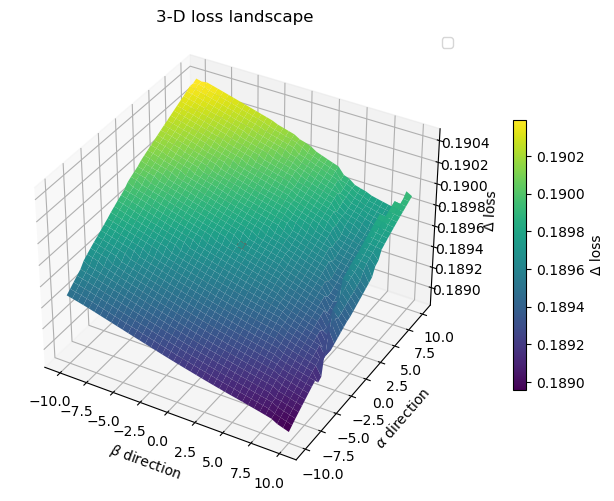

In [ ]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_0_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)

#model_nogcs.load_state_dict(torch.load("./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best_val_loss.pth", weights_only=False))

train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "train",        
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path  = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
) 
train_loader = DataLoader(
        train_ds,
        batch_size=16,  
        shuffle=False,
        num_workers=8,  
        pin_memory=True
    )

criterion = CoxLoss()
fig, _ = plot_loss_landscape_3d(model,
                             train_loader,
                             criterion,
                             extent=10.,
                             steps=40,
                             device=device)
plt.show()

In [4]:
import torch, math
from torch.nn.utils import parameters_to_vector

# ---------------------------------------------------------------------------
def hvp(loss_fn, params, vec, inputs, targets, create_graph=False):
    """
    One Hessian-vector product for arbitrary (inputs, targets) batches.
    """
    # forward & first-order grads
    loss = loss_fn(inputs, targets)
    g1   = torch.autograd.grad(
              loss, params, create_graph=True, allow_unused=True)
    flat_g1 = torch.cat([
        (torch.zeros_like(p).view(-1) if g is None else g.contiguous().view(-1))
        for p, g in zip(params, g1)
    ])

    # ⟨g1, v⟩
    dot  = (flat_g1 * vec).sum()

    # second-order grads: ∇(⟨g1, v⟩)
    g2 = torch.autograd.grad(
             dot, params, retain_graph=False, allow_unused=True,
             create_graph=create_graph)

    flat_g2 = torch.cat([
        (torch.zeros_like(p).view(-1) if g is None else g.contiguous().view(-1))
        for p, g in zip(params, g2)
    ])

    return flat_g2.detach()                      # no grad outside

# ---------------------------------------------------------------------------
def topk_hessian_eigs(model, loss_fn, data_loader,
                      k=2, iters=20, tol=1e-6, device=None):
    """
    Power / block-Lanczos for the k largest eigen-pairs of the Hessian.
    * Works with *any* input structure.
    * Never fails when some params are unused by the batch.
    """
    if device is None:
        device = next(model.parameters()).device
    model.to(device).eval()

    # grab *one* batch to define the local Hessian
    inputs_raw, targets_raw = next(iter(data_loader))

    # move recursively to device
    def _to(x):
        if torch.is_tensor(x):       return x.to(device)
        if isinstance(x, (list,tuple)): return type(x)(_to(t) for t in x)
        return x
    inputs, targets = _to(inputs_raw), _to(targets_raw)

    # loss_fn must close over model & criterion --------------
    params = [p for p in model.parameters() if p.requires_grad]
    n_dim  = sum(p.numel() for p in params)

    # initial orthonormal block
    Q = torch.randn(k, n_dim, device=device)
    Q, _ = torch.linalg.qr(Q.T, mode='reduced')     # orthonormal cols
    Q = Q.T                                         # rows

    evals = torch.zeros(k, device=device)

    for _ in range(iters):
        # H·Qᵀ   (stack k Hessian-vector products)
        HQ = torch.vstack([
            hvp(loss_fn, params, q, inputs, targets, create_graph=False)
            for q in Q
        ])

        # small k×k Gram matrix
        G = HQ @ Q.T
        w, U = torch.linalg.eigh(G)
        idx  = torch.argsort(w, descending=True)
        w, U = w[idx], U[:, idx]                    # sort largest→smallest

        # Ritz vectors in full space
        Q_next = (U.T @ Q)                         # k × n_dim

        # convergence check
        if (Q_next - Q).norm() < tol:
            evals = w
            break

        Q = Q_next
        evals = w

    eigvecs = [q / q.norm() for q in Q]            # guarantee unit length
    return evals[:k].cpu(), eigvecs[:k]


/tmp/ipykernel_2503669/1535983693.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: ['gamma']
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 2.035e-07, λ₂ = -1.836e-06


Scanning landscape: 100%|██████████| 45/45 [11:36<00:00, 15.47s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


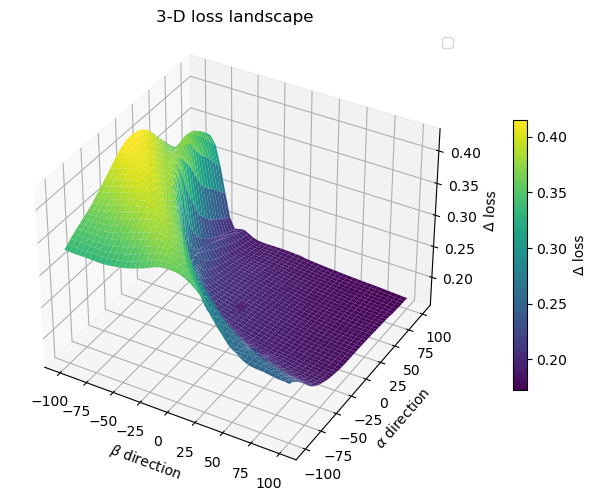

In [13]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]         
# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()

/tmp/ipykernel_2503669/671101879.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 4.329e-07, λ₂ = -1.02e-06


Scanning landscape: 100%|██████████| 45/45 [11:30<00:00, 15.33s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


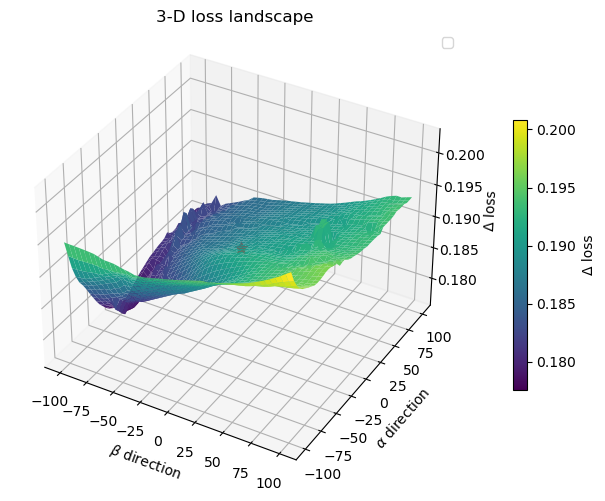

In [11]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_0_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()

/tmp/ipykernel_2503669/899778747.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 0, λ₂ = 0


Scanning landscape: 100%|██████████| 45/45 [12:03<00:00, 16.08s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


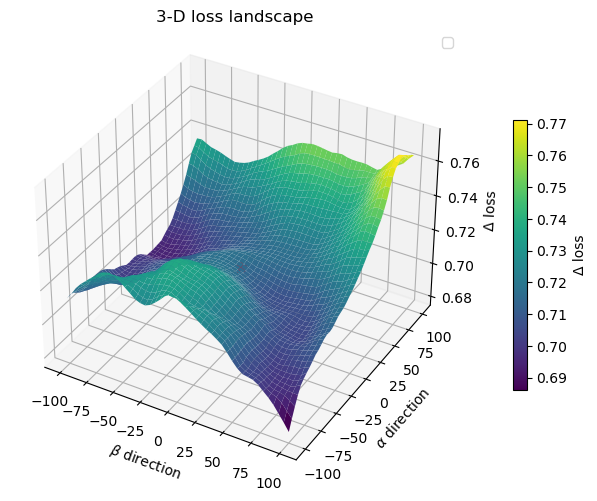

<Figure size 640x480 with 0 Axes>

In [14]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_1/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_1/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_1_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 1,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()
plt.savefig("landscape_fold1_gcs.pdf")

/tmp/ipykernel_2503669/1384226502.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: ['gamma']
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 0, λ₂ = 0


Scanning landscape: 100%|██████████| 45/45 [12:05<00:00, 16.13s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


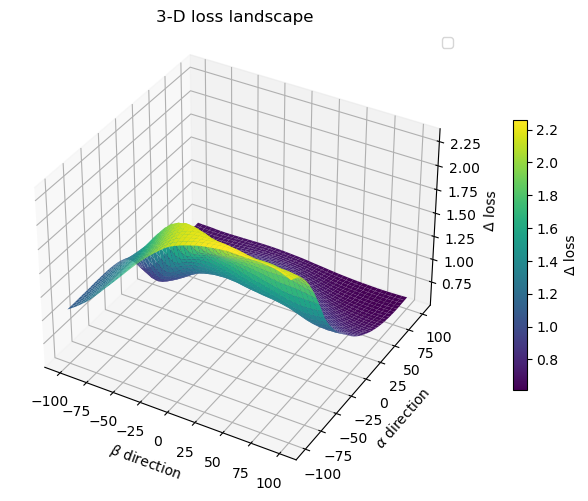

<Figure size 640x480 with 0 Axes>

In [16]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_1/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_1/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_1_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 1,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()
plt.savefig("landscape_fold1_nogcs.pdf")

/tmp/ipykernel_2503669/1825807678.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 8.025e-14, λ₂ = -3.555e-14


Scanning landscape: 100%|██████████| 45/45 [12:19<00:00, 16.44s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


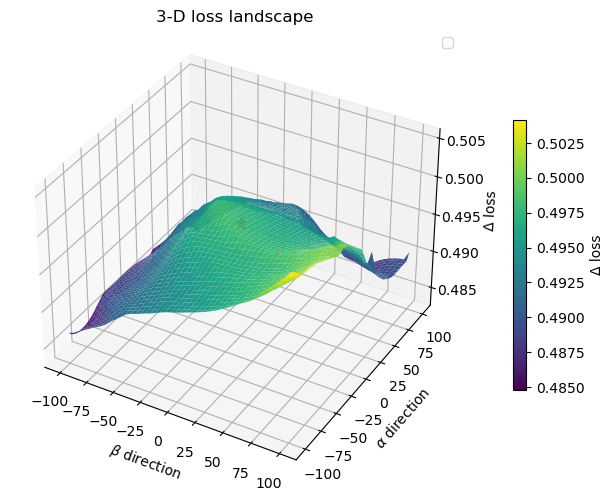

<Figure size 640x480 with 0 Axes>

In [17]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_2/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_2/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_2_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 2,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()
plt.savefig("landscape_fold2_gcs.pdf")

/tmp/ipykernel_2503669/3052524936.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: ['gamma']
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 1.685e-05, λ₂ = 9.997e-06


Scanning landscape: 100%|██████████| 45/45 [12:19<00:00, 16.43s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


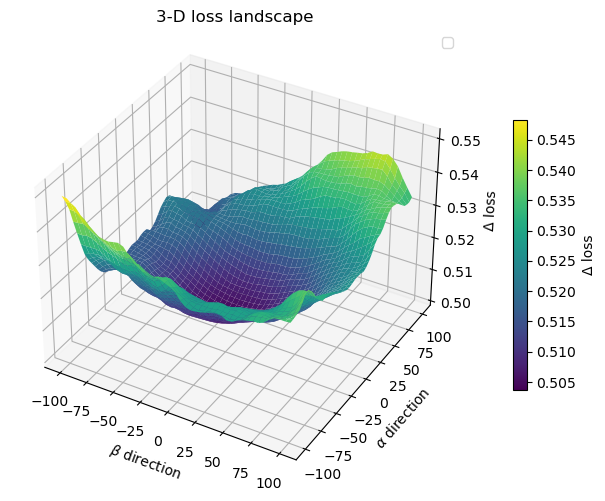

<Figure size 640x480 with 0 Axes>

In [18]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_2/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_2/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_2_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 2,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device)
plt.show()
plt.savefig("landscape_fold2_nogcs.pdf")

In [ ]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_3/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_3/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_3_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 3,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device, title="Loss Landscape")

plt.savefig("landscape_fold3_gcs.pdf",bbox_inches='tight', dpi=300)

Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...


/tmp/ipykernel_3464570/210884546.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


λ₁ = 9.66e-15, λ₂ = 0


Scanning landscape:  80%|████████  | 36/45 [09:09<02:17, 15.25s/it]

Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...


/tmp/ipykernel_6130/1650183715.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


λ₁ = -1.354e-07, λ₂ = -0.0003013


Scanning landscape: 100%|██████████| 45/45 [09:51<00:00, 13.15s/it]


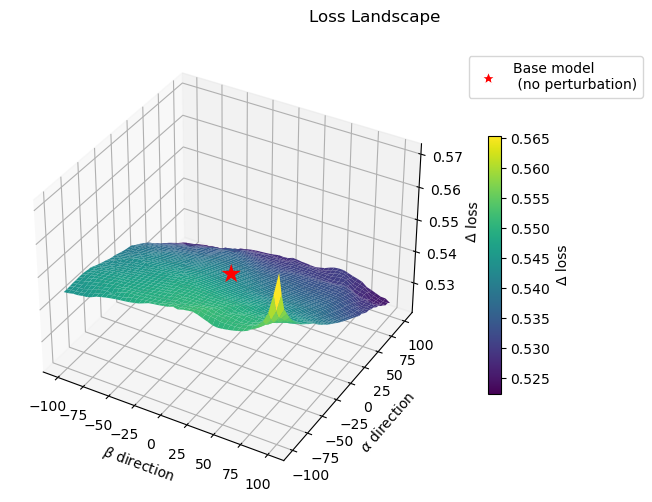

In [8]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_3/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_3/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_3_best_val_loss.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model_nogcs.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model_nogcs.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 3,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model_nogcs, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model_nogcs(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model_nogcs,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model_nogcs,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device, title="Loss Landscape")

plt.savefig("landscape_fold3_nogcs.pdf",bbox_inches='tight', dpi=300)

/tmp/ipykernel_6130/327803018.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = 2.694e-14, λ₂ = -1.17e-14


Scanning landscape: 100%|██████████| 45/45 [10:16<00:00, 13.69s/it]


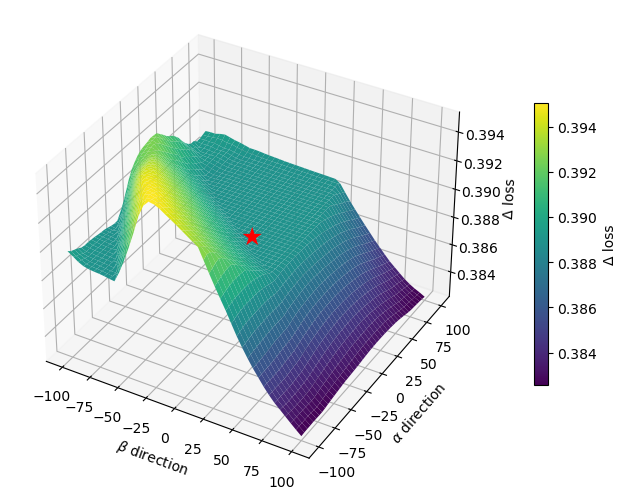

In [ ]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new_gcs import madpe_nobackbone
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model = madpe_nobackbone(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller/fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller_fold_4_best.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 4,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device, title="Loss Landscape")

plt.savefig("landscape_fold4_gcs.pdf",bbox_inches='tight', dpi=300)

/tmp/ipykernel_6130/1514795798.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")


Still missing: []
Still unexpected: []
Estimating top-2 Hessian directions ...
λ₁ = -7.328e-07, λ₂ = -1.653e-05


Scanning landscape: 100%|██████████| 45/45 [10:26<00:00, 13.91s/it]


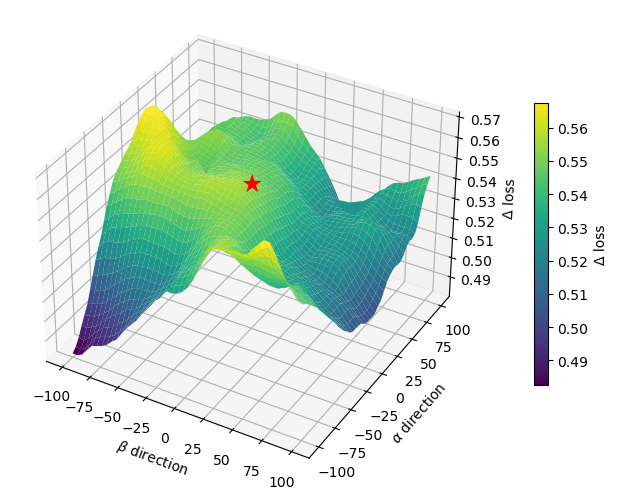

In [12]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict

from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from pyhessian import hessian   # pip install pyhessian
import torch, itertools
set_global_seed(seed=SEED)

device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_4/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_4_best_val_loss.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model_nogcs.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)
model_nogcs.to(device).eval()                                      # very important

# ---------- 2. dataset & dataloader ---------------------------------------
train_ds = MultimodalCTWSIDatasetSurv(
    fold = 3,
    split = "test",
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = False,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
)

# --- build *dictionary* loader (for loss-landscape plotting) ---------------
loader_dict = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True      # ← original layout: dicts
)

# --- build *tuple* loader (for PyHessian) ----------------------------------
def collate_hessian(batch):
    rad   = torch.stack([b["ct_feature"]    for b in batch])
    histo = torch.stack([b["wsi_feature"]   for b in batch])
    mask  = torch.stack([b["modality_mask"] for b in batch])
    stime = torch.stack([b["survtime"]      for b in batch])
    censor= torch.stack([b["censor"]        for b in batch])
    return (rad, histo, mask), (stime, censor)

loader_hessian = DataLoader(
    train_ds,
    batch_size   = 16,
    shuffle      = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = collate_hessian        # ← tuple of inputs & targets
)

# --- model / criterion wrappers (same as before) ---------------------------
class HazardWrapper(torch.nn.Module):
    def __init__(self, core, device):
        super().__init__(); self.core, self.device = core, device
    def forward(self, inputs):
        rad, histo, mask = (t.to(self.device) for t in inputs)
        return self.core(rad, histo, modality_flag=mask)["hazard"]

wrapped_model = HazardWrapper(model_nogcs, device).to(device)
# -------------------------------------------------------------
cox  = CoxLoss().to(device)

def loss_fn(inputs, targets):
    rad, histo, mask = inputs
    stime, censor    = targets
    hazard = model_nogcs(rad, histo, modality_flag=mask)["hazard"]
    return cox(hazard, stime, censor)

criterion_hessian = lambda out, target: cox(out, *[t.to(device) for t in target])
print("Estimating top-2 Hessian directions ...")
eigvals, (d1, d2) = topk_hessian_eigs(
    model        = model_nogcs,
    loss_fn      = loss_fn,
    data_loader  = loader_hessian,   # tuple-batch loader
    k            = 2,
    iters        = 20,
    device       = device)

print(f"λ₁ = {eigvals[0]:.4g}, λ₂ = {eigvals[1]:.4g}")

fig, _ = plot_loss_landscape_3d(
            model       = model_nogcs,
            data_loader = loader_dict,          # dict-batch loader (for plotting)
            criterion   = cox,
            directions  = (d1, d2),
            extent      = 100.,
            steps       = 45,
            device      = device, title="Loss Landscape")

plt.savefig("landscape_fold4_nogcs.pdf",bbox_inches='tight', dpi=300)

Still missing: []
Still unexpected: []


/tmp/ipykernel_1007085/1780383442.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
Scanning landscape: 100%|█

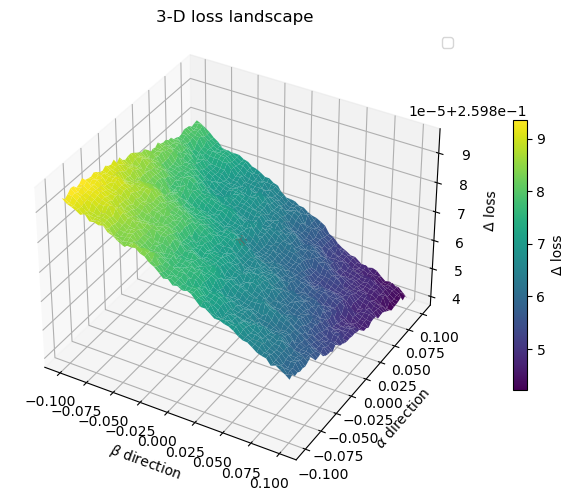

In [11]:
from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from models.dpe.main_model_nobackbone_surv_new import madpe_nobackbone as madpe_nobackbone_nogcs
from torch.utils.data import DataLoader
from training.losses import CoxLoss
from collections import OrderedDict
device = "cuda:0"
model_nogcs = madpe_nobackbone_nogcs(
    rad_input_dim=1024,
    histo_input_dim=768,
    inter_dim=256,
    token_dim=256
)
ckpt_path = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best_val_loss.pth"
checkpoint   = torch.load(ckpt_path, map_location="cuda:0")
state_dict   = checkpoint["model_state_dict"]          

# ── optional: strip a 'module.' prefix if the model was saved with DataParallel ──
#clean_state = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
# 3️⃣ copy weights into the model
missing, unexpected = model_nogcs.load_state_dict(state_dict, strict=False)
print("Still missing:", missing)
print("Still unexpected:", unexpected)

#model_nogcs.load_state_dict(torch.load("./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip/fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_fold_0_best_val_loss.pth", weights_only=False))

train_ds = MultimodalCTWSIDatasetSurv(
    fold = 0,
    split = "train",        # use held-out data for fair comparison
    ct_path = "../MedImageInsights/embeddings_output_cptacpda",
    wsi_path = "../trident/trident_processed/20x_224px_0px_overlap/slide_features_titan",
    labels_splits_path  = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv",
    missing_modality_prob = 0.0,
    missing_modality = "both",
    require_both_modalities = True,
    pairing_mode = "one_to_one",
    allow_repeats = False,
    pairs_per_patient = None,
) 
train_loader = DataLoader(
        train_ds,
        batch_size=16,
        shuffle=False,
        num_workers=4,  
        pin_memory=True
    )

criterion = CoxLoss()
fig, _ = plot_loss_landscape_3d(model_nogcs,
                             train_loader,
                             criterion,
                             extent=.1,
                             steps=50,
                             device=device)
plt.show()